<a href="https://colab.research.google.com/github/myidispg/Kaggle-competitions/blob/master/kaggle_jigsaw_unintended_bias_toxicity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A notebook for the Jigsaw Unintended Bias in Toxicity Classification on Kaggle.
https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview

##All the necessary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from zipfile import ZipFile 

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PAD_token = 0
SOS_token = 1
EOS_token = 2

dataset_directory = 'kaggle_jigsaw_unintended_bias/'

print(pd.__version__)
print(device)

0.22.0
cuda


In [2]:
os.environ['KAGGLE_USERNAME'] = "myidispg"
os.environ['KAGGLE_KEY'] = "c991620902499acb95ee0c402d169f34"
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification


  0% 0.00/221k [00:00<?, ?B/s]
100% 221k/221k [00:00<00:00, 33.4MB/s]
 74% 9.00M/12.1M [00:00<00:00, 15.7MB/s]
100% 12.1M/12.1M [00:00<00:00, 19.0MB/s]
100% 272M/273M [00:04<00:00, 49.1MB/s]
100% 273M/273M [00:04<00:00, 66.4MB/s]


## Check whether the test, train and sample_submission zips have been downloaded.

In [3]:
print(os.listdir())

['.config', 'train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip', 'sample_data']


## Unzip the files and check.

In [4]:
# unzip the train.csv file
train_zip_filename = 'train.csv.zip'
with ZipFile(train_zip_filename, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall(dataset_directory) 
    print('Done!')
    
# unzip the test.csv file
train_zip_filename = 'test.csv.zip'
with ZipFile(train_zip_filename, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall(dataset_directory) 
    print('Done!') 
    
# unzip the sample_submission.csv file
train_zip_filename = 'sample_submission.csv.zip'
with ZipFile(train_zip_filename, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall(dataset_directory) 
    print('Done!') 

File Name                                             Modified             Size
train.csv                                      2019-03-28 21:17:38    816211476
Extracting all the files now...
Done!
File Name                                             Modified             Size
test.csv                                       2019-03-28 15:08:42     30179878
Extracting all the files now...
Done!
File Name                                             Modified             Size
sample_submission.csv                          2019-03-28 15:08:42      1167854
Extracting all the files now...
Done!


## Check if the files have been extracted properly

In [5]:
if set(['train.csv', 'test.csv', 'sample_submission.csv']).issubset(os.listdir(dataset_directory)):
  print('The dataset has been extracted properly.')
else:
  print('There was some issue in dataset download or extraction.')
 
print(f'The contents of the dataset directory are- {os.listdir(dataset_directory)}')

The dataset has been extracted properly.
The contents of the dataset directory are- ['sample_submission.csv', 'train.csv', 'test.csv']


## Load the training data in a pandas dataframe

In [6]:
df_train = pd.read_csv(dataset_directory + 'train.csv')
# print(f'The first entry in train dataframe is: \n{df_train[:1]}\n')
print(f'The column names in train dataframe are- {list(df_train.columns.values)}\n\n')

df_test = pd.read_csv(dataset_directory + 'test.csv')
# print(f'The first entry in test dataframe is: \n{df_train[:1]}\n')
print(f'The column names in test dataframe are- {list(df_test.columns.values)}')


The column names in train dataframe are- ['id', 'target', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit', 'identity_annotator_count', 'toxicity_annotator_count']


The column names in test dataframe are- ['id', 'comment_text']


##Convert the dataframes to numpy arrays
Convert the dataframes to numpy arrays. Also, the id, target and comment_text columns of the train dataset are preserved. The others are discarded as of now.

In [7]:
df_train = df_train.iloc[:, :3]
np_train = df_train.iloc[:, :].values
print(np_train[100])
np_test = df_test.iloc[:, :].values
print(np_test[100])

del df_train, df_test

[239722 0.0
 'Loving this collection. Cant wait till Season 2 is released. Should be any day now according to http://yeezy-season2.com/']
[7000100
 'Did you even read the editorial?\n\n"The best course is for the democratic world to continue to demand the return of the country’s legislature, and the end of the sham constituent assembly that usurped it. Impartial outsiders, working with both the opposition and Mr. Maduro, could help negotiate a schedule for the return of legitimate elections."\n\nHow exactly do you interpret that as a call for a military invasion?']


## Normalize the strings, stem, convert to lower case and remove all punctutations.

Will try stemming later. Stemming might result in information loss while the model will try to understand the context of the sentence.

Note: The symbol to remove apostrophes was found on- https://stackoverflow.com/questions/44296593/how-to-remove-apostrophe-marks-from-a-string-in-python?rq=1

In [8]:
import re
import unicodedata

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeAndStemString(s):
    s = unicodeToAscii(s.lower().strip())
#     s = [word.replace("'", "") for word in s.split()]
#     for i in range(len(s)):
#       s[i] = ps.stem(s[i])
    s = re.sub(r"http[s]?:\/\/\S+", '', s)
    s = s.replace(u"\u2019", "") # remove apostrophes
    s = re.sub(r"([.!?])", r" \1", s) # remove punctuations
    s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s) # remove all characters except alphabets and .!?
    return s

print('Normalizing dataset....')
for i in range(len(np_test)):
  np_test[i][1] = normalizeAndStemString(str(np_test[i][1]))
# print(np_test[100])
print('Normalized Test dataset')
for i in range(len(np_train)):
  np_train[i][2] = normalizeAndStemString(str(np_train[i][2]))
# print(np_train[100])
print('Normalized Train dataset')


Normalizing dataset....
Normalized Test dataset
Normalized Train dataset


## Extract x_train, y_train, x_valid, y_valid and x_test from the numpy arrays.
The train dataset will be split into train and validation set to measure the performance of the model.

In [9]:
x_train = np_train[:, 2]
y_train = np_train[:, 1]

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)

print(f'The len of the train set is: {x_train.shape[0]}')
print(f'The len of the validation set is: {x_valid.shape[0]}')

y_train = np.where(y_train >= 0.5, 1, 0)
y_valid = np.where(y_valid >= 0.5, 1, 0)

The len of the train set is: 1443899
The len of the validation set is: 360975


## Now that we have the train, valid and test set, we can now work on creating a vocabulary for all the comments.
The vocabulary will have word2idx, idx2word, word2count, max_sent_length and n_words.

In [0]:
class Vocab:
  
  def __init__(self):
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
    self.n_words = 2
    self.max_sent_length = 0
    
  def addSentence(self, sentence):
    sent_length = len(sentence.split(' '))
    self.max_sent_length = sent_length if sent_length > self.max_sent_length else self.max_sent_length        
    for word in sentence.split(' '):
      self.addWord(word)
      
  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1
      
      
vocab = Vocab()

## Go through all the sentences in the train, validation and test set and add to vocabulary.


In [11]:
# Add all words from test set to vocabulary.
for line in np_test:
  vocab.addSentence(line[1])
  
print(f'Number of words in vocabulary after adding test set: {vocab.n_words}')

# Add all words from train set to vocabulary.
for line in x_train:
  vocab.addSentence(line)
  
print(f'Number of words in vocabulary after adding train set: {vocab.n_words}')

# Add all words from validation set to vocabulary.
for line in x_valid:
  vocab.addSentence(line)
  
print(f'Number of words in vocabulary after adding validation set: {vocab.n_words}')

MAX_LENGTH = vocab.max_sent_length


Number of words in vocabulary after adding test set: 73184
Number of words in vocabulary after adding train set: 267123
Number of words in vocabulary after adding validation set: 296666


## Now that the vocabulary is ready, moving onto some Exploratory Data Analysis.
In this section, I will get the-
1. Number of samples
2. Number of samples per class(toxic or non-toxic)
3. Median number of words per sample

The total number of combined samples of the train and validation set are: 1804874
The number of toxic samples are: 144334
The number of non-toxic samples are: 1660540


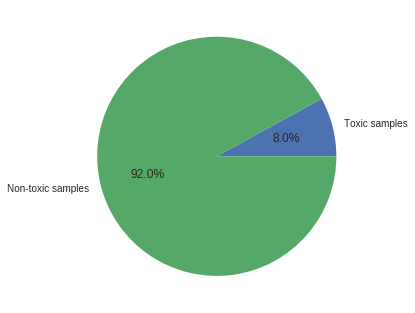

'By the output of the pie chart, it will be clear that the Toxic comments are very less in number than non-toxic comments.'

In [12]:
print(f'The total number of combined samples of the train and validation set are: {x_train.shape[0] + x_valid.shape[0]}')

# ------Calculate number of samples per class-----------------------------------
num_toxic_samples = 0
num_non_toxic_samples = 0

for entry in y_train:
  if entry > 0.5:
    num_toxic_samples += 1
  else:
    num_non_toxic_samples += 1
    
for entry in y_valid:
  if entry > 0.5:
    num_toxic_samples += 1
  else:
    num_non_toxic_samples += 1
  
print(f'The number of toxic samples are: {num_toxic_samples}')
print(f'The number of non-toxic samples are: {num_non_toxic_samples}')

plt.pie([num_toxic_samples, num_non_toxic_samples], labels=['Toxic samples', 'Non-toxic samples'], autopct='%1.1f%%',)
plt.show()
# ------------------------------------------------------------------------------
"""By the output of the pie chart, it will be clear that the Toxic comments are very less in number than non-toxic comments."""

In [13]:
#----- Find number of words per sample------------------------------------------
num_words = []

for line in np_test:
  num_words.append(len(str(line).split(' ')))
  
for line in x_train:
  num_words.append(len(line.split(' ')))
  
for line in x_valid:
  num_words.append(len(line.split(' ')))
  
import statistics

print(f'The median of the sentence lengths is: {statistics.median(num_words)}')
print(f'The maximum sentence length is: {vocab.max_sent_length}')
#-------------------------------------------------------------------------------

The median of the sentence lengths is: 40.0
The maximum sentence length is: 503


## Creating sequences from words.
Some functions to create sequences of indexes for a given sentence. The output will be a Pytorch tensor.

In [14]:
# x_train before creating sequences
print(x_train[2])

def indexesFromSentence(sentence):
    return [vocab.word2index[word] for word in sentence.split(' ')]
    
def tensorFromSentence(sentence):
    indexes = indexesFromSentence(sentence)
    indexes.append(EOS_token)
    if len(indexes) < MAX_LENGTH:
      for i in range(len(indexes), MAX_LENGTH):
        indexes.append(PAD_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

print(f'Making sure the tensors are of max_length. The shape should be [{MAX_LENGTH}, 1]: {tensorFromSentence(x_train[2]).shape}')

and if you want really really unfriendly people visit toronto .
Making sure the tensors are of max_length. The shape should be [503, 1]: torch.Size([503, 1])


##Define the GRU model.
The model will take an input word's index, fetch up the corresponding embedding and then run through a Gated Recurrent Unit to return an Output and a Hidden State. The output will further be passed on to an ANN.

In [15]:
class GRU(nn.Module):
  def __init__(self, vocab_size, embedding_dims, hidden_size, num_layers):
    super(GRU, self).__init__()
    self.vocab_size = vocab_size
    self.embedding_dims = embedding_dims
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.embedding = nn.Embedding(self.vocab_size, self.embedding_dims)
    self.gru = nn.GRU(self.embedding_dims, self.hidden_size, num_layers=self.num_layers)
  
  def forward(self, input, hidden_state):
    embedded = self.embedding(input).view(1, 1, -1) # Output of size -> 1, 1, embedding_dims
    output = embedded
    # dims of hidden_state = 2, 1, hidden_size (2 because 2 layers)
    output, hidden_state = self.gru(output, hidden_state)
    return output, hidden_state
  
  def initHidden(self):
    return torch.randn(self.num_layers, 1, self.hidden_size, device=device)
    
    
class ANN(nn.Module):
  def __init__(self, input_size):
    super(ANN, self).__init__()
    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 2)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, input):
    output = F.dropout(F.relu(self.fc1(input)), p=0.2)
    output = F.dropout(F.relu(self.fc2(output)), p=0.2)
    output = self.fc3(output)
#     print(f'Before softmax: {output}')
#     output = self.softmax(output)
    return output
  
for i in range(10):
  input_tensor = tensorFromSentence(x_train[i])
  hidden = gru.initHidden()
  loss = 0
  for index in range(input_tensor.shape[0]):
    output, hidden = gru(input_tensor[index], hidden)
    
  y_pred = ann(output)
#     y_pred = nn.LogSoftmax(y_pred)
#   print(f'after softmax: {y_pred}')
#     topv, topi = y_pred.topk(1)
#     print(f'topv: {topv[0][0][0]}, topi: {topi}')
#     print(y_pred, torch.tensor(y_train[2], device=device))
#     loss += criterion(topv.view(1, -1), torch.tensor(y_train[index], device=device).view(1, ))
  loss += criterion(y_pred.view(1, -1), torch.tensor(y_train[index], device=device).view(1, ))
  loss.backward()
  gru_optimizer.step()
  ann_optimizer.step()
  print(f'loss: {loss}')
  loss = 0
  

loss: 0.7723184823989868
loss: 0.741515040397644
loss: 0.6970697641372681
loss: 0.6665502190589905
loss: 0.6505482792854309
loss: 0.576484203338623
loss: 0.48942267894744873
loss: 0.47495752573013306
loss: 0.4211884140968323
loss: 0.32546544075012207


## Some functions to find time elapsed
These functions help to calculate the elapsed time and the remaining time.

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

## Training a single sentence.

In [0]:
def trainSentence(input_tensor, target_label, gru, ann, gru_optimizer, ann_optimizer, criterion):
  
  
  hidden_state = gru.initHidden()
  
  gru_optimizer.zero_grad()
  ann_optimizer.zero_grad()
  
  loss = 0
  # pass the whole sentence through the rnn. 
  for index in range(input_tensor.shape[0]):
    output, hidden_state = gru(input_tensor[index], hidden_state)
  
  # feed the output tensor to the ann.
  y_pred = ann(output)
  loss += criterion(y_pred.view(1, -1), torch.tensor(target_label, device=device).view(1, ))
  
  loss.backward()
  gru_optimizer.step()
  ann_optimizer.step()
  
  return loss

In [0]:
def trainIters(gru, ann, print_every=5000, plot_every=5000, learning_rate=0.01):
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0
  
  n_iters = x_train.shape[0]
  
  for iter in range(1, n_iters+1):
    input_tensor = tensorFromSentence(x_train[iter-1])
    
    loss = trainSentence(input_tensor, y_train[iter-1], gru, ann, gru_optimizer, ann_optimizer, criterion)
    
    print_loss_total += loss
    plot_loss_total += loss
    
    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print(f'Time since: {timeSince(start, iter/n_iters)}; Iteration: {iter}; Percentage elapsed: {iter/n_iters*100}; Loss: {print_loss_avg}')
      
    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / pot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0
      
  showPlot()
    

In [0]:
EMBEDDING_DIMS = 128
HIDDEN_SIZE = 256
    
gru = GRU(vocab.n_words, EMBEDDING_DIMS, HIDDEN_SIZE, 2).to(device)
ann = ANN(HIDDEN_SIZE).to(device)

criterion = nn.CrossEntropyLoss()

gru_optimizer = optim.SGD(gru.parameters(), lr=0.01)
ann_optimizer = optim.SGD(ann.parameters(), lr=0.01)

trainIters(gru, ann)